In [6]:
import pymongo
from pprint import pprint
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Set, Tuple
import functools as ft
import numpy as np
import random
#from spacy.tokens import DocBin
from spacy import displacy
from tqdm import tqdm
from constants import utc_to_dt, COLL, PSAW, PRAW
import spacy
#from explore_build import text_to_spacy
from collections import Counter
from praw import Reddit
from psaw import PushshiftAPI
from IPython.core.display import display, HTML, Latex
nlp = spacy.load("en_core_web_sm")

In [243]:
"""Retrieve a sorted list of the top posters from the given collection."""
res = COLL.find({}).limit(10)

AttributeError: 'Cursor' object has no attribute 'pretty'

AttributeError: 'list' object has no attribute 'pretty'

# Gather top n users
Top users should not be moderators

In [6]:
def sorted_posters(coll: pymongo.collection.Collection, 
                   n: Optional[int] = None,
                   subr: Optional[str] = None) -> List[str]:
    """Retrieve a sorted list of the top posters from the given collection."""
    query = [
        {"$group": {"_id": "$username",
                    "count": {"$sum": 1}}},
        {"$sort": {"count": -1}}]
    if n:
        query.append({"$limit": n})
    if subr:
        query.insert(0, {"$match": {"subr": subr}})
    res = coll.aggregate(query)
    users = [rec["_id"] for rec in res]
    filt_users = list(filter(lambda x: x and pd.notna(x), users))
    return filt_users


def user_posts(praw: Reddit,
               psaw: PushshiftAPI, 
               user: str,
               filt_mods: Optional[bool] = None) -> Optional[pd.DataFrame]:
    """Retrieve the full reddit posting history for the given users."""
    print("On user:", user)
    if filt_mods and praw.redditor(user).is_mod:
        return None
    author = praw.redditor(user)
    subs = list(author.submissions.top(limit=None))
    comms = list(author.comments.top(limit=None))
    username = [user] * (len(subs) + len(comms))
    text = [s.selftext for s in subs] + [c.body for c in comms]
    subr = [s.subreddit for s in subs] + [c.subreddit for c in comms]
    is_sub = [True] * len(subs) + [False] * len(comms)
    ids = [s.id for s in subs] + [c.id for c in comms]
    data = {"username": username, "text": text, "subreddit": subr,
            "is_sub": is_sub, "id": ids}
    df = pd.DataFrame(data)
    return df


def users_posts(users: List[str],
                praw: Reddit,
                psaw: PushshiftAPI, 
                limit: int,
                filt_mods: Optional[bool] = None) -> List[pd.DataFrame]:
    """
    Retrieve the full reddit posting history for all given users.

    :param conn: a psaw connection object
    :param users: a list of usernames

    :return: a dataframe of post features
    """
    if len(users) <= 0:
        return []
    dfs = users[:limit] |> map$(-> user_posts(praw, psaw, _, filt_mods)) \
                        |> filter$(-> type(_) != None) \
                        |> list
    n_retrieved = len(dfs)
    if n_retrieved < limit:
        return dfs + users_posts(users[n_retrieved:], praw, psaw, \
                                 limit - n_retrieved, filt_mods)
    return dfs

In [205]:
sub = PRAW.redditor("Comfycodone").submissions.top(limit=None)

In [206]:
for s in sub:
    print(s)

Forbidden: received 403 HTTP response

In [207]:
top_users = sorted_posters(COLL)
top_histories = users_posts(top_users, PRAW, PSAW, 6) |> pd.concat

On user: R1chPorter


KeyboardInterrupt: 

In [ ]:
top_histories

## Top N User Reddit Data

### 1. Load data from Mongo/Reddit

In [ ]:
# read in data and filter missing text
# users_df = pd.read_csv("data/top10_users.csv").dropna()
users_df = top_histories

In [ ]:
# convert text to spacy docs
text_docs = [t for t in users_df["text"].tolist() if type(t) == str]
spacy_docs = []
for t in tqdm(text_docs):
    spacy_docs.append(nlp(t))

In [28]:
# add spacy docs to users dataframe
# temp_docs = text_docs.copy()
# spacy_col = [temp_docs.pop() if type(t) == str else None for t in users_df["text"].tolist()]
users_df["spacy"] = spacy_docs

### Optional write spacy to disk

In [7]:
# write space docs to disk
doc_bin = DocBin(attrs=["LEMMA", "ENT_IOB", "ENT_TYPE"],
                 store_user_data=True)
for doc in tqdm(spacy_docs):
    doc_bin.add(doc)
    
# write bytes data to file
spacy_fp = "data/top10_spacy.spacy"
bytes_data = doc_bin.to_bytes()
out_f = open(spacy_fp, "wb")
out_f.write(bytes_data)

100%|██████████| 174934/174934 [00:20<00:00, 8541.04it/s] 


28832714

In [8]:
# sample read in of written docs
docbin = DocBin().from_bytes(open(spacy_fp, "rb").read())
disk_docs = docbin.get_docs(nlp.vocab)
disk_docsl = list(disk_docs)

### 2. Extract entities

In [224]:
users_df.head(100)

,username,text,subreddit,is_sub,id,spacy,ents
0,R1chPorter,,funny,True,asmhey,(),None
1,R1chPorter,,opiates,True,anz3hi,(),None
2,R1chPorter,,opiates,True,ad14c5,(),None
3,R1chPorter,,memes,True,ao9i81,(),None
4,R1chPorter,,memes,True,arqpri,(),None
5,R1chPorter,No images on r/opiates ... Darknet Markets are...,opiates,True,blftq5,"(No, images, on, r, /, opiates, ..., Darknet, ...","[(Darknet, Markets), (Dread), (WSM), (Wickr, /..."
6,R1chPorter,God someone mentioned this on this sub some sh...,opiates,True,aouyjg,"(God, someone, mentioned, this, on, this, sub,...","[(50, %), (the, other, day)]"
7,R1chPorter,,fuckthepopulation,True,aj1xru,(),None
8,R1chPorter,,memes,True,arqsll,(),None
9,R1chPorter,,opiates,True,ar9pt8,(),None


In [124]:
users_df["ents"] = map(-> list(_.ents) if len(_.ents) > 0 else None, users_df["spacy"].tolist()) |> list
ents_df = users_df.dropna()

In [181]:
def get_ents(u: str):
    grouped_ents = ents_df.loc[ents_df["username"] == u, :]["ents"].tolist()
    return ft.reduce((x, y) -> x + y, grouped_ents, [])

In [187]:
def ents_by_type(ents, etype):
    filt_ents = ents |> filter$(-> _.label_ == etype) |> list
    gpes_text = filt_ents |> map$(-> _.text.lower().strip(".")) |> list
    return gpes_text

In [236]:
u1_ents = get_ents("realcat67")
u1_gpe = ents_by_type(u1_ents, "MONEY")

In [237]:
gpe_counts =  sorted(dict(Counter(u1_gpe)).items(), key=-> _[1], reverse=True)

In [238]:
gpe_counts

[('10', 3),
 ('4', 2),
 ('four hundred dollars', 1),
 ('around $300', 1),
 ('twenty dollars', 1),
 ('15.00', 1),
 ('#sadbunny', 1),
 ('$$$', 1),
 ('hundreds of dollars', 1),
 ('3', 1)]

### 3. User Plots

In [228]:
users_df["username"].unique()

array(['R1chPorter', 'cozywarmedblanket', 'realcat67'], dtype=object)

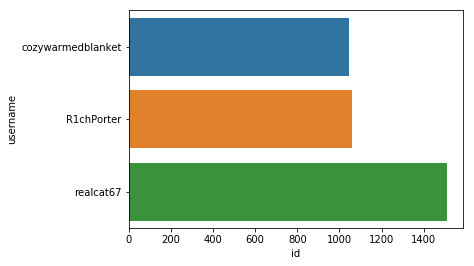

In [32]:
user_counts = users_df.groupby("username").count().sort_values("id").reset_index()
sns.barplot(y="username", x="id", data=user_counts, orient="h")
plt.show()

In [51]:
# visualize entities
docs = ents_df["spacy"].tolist()[75:80]
vis_docs = [d for d in docs if len(d.ents) > 0]
for i, d in enumerate(vis_docs):
    print("Doc:", i)
    display(HTML(displacy.render(d, style='ent', page=True)))

NameError: name 'ents_df' is not defined

In [46]:
users_df["gpes"] = users_df["spacy"].apply(lambda x: [e for e in x.ents if e.label_ == "GPE"])

In [78]:
gpes_by_user

,username,gpes
0,FashionablyFake,"[(Kilos), (soooo), (Dallas), (Whatevz), (bk), ..."
1,KickerS12X,"[(kiddo), (Vermont), (xanax), (north, troy), (..."
2,OlDirtyBurton,"[(APVP), (US), (Adderall), (US), (US), (Tina),..."
3,chasing-d0pamine,"[(Wharton), (Adderall), (america), (Adderall),..."
4,heroinking,"[(turkey), (turkey), (APVP), (APVP), (turkey),..."
5,spinderella69,"[(NY), (Molly), (kinda), (Kratom), (Kratom), (..."
6,street_philatelist,"[(Fentanyl, Warnings, State), (SN), (Florida),..."
7,traceyh415,"[(R.C.), (Chicago), (Phoenix), (AZ), (Seattle)..."


In [73]:
gpes_by_user = users_df.groupby("username").agg({"gpes": lambda x: ft.reduce(lambda acc, y: acc + y, x)}).reset_index()

In [83]:
Counter([e.text for e in gpes_by_user["gpes"][4]]).most_common()

[('APVP', 127),
 ('Adderall', 107),
 ('US', 54),
 ('Seroquel', 25),
 ('Xanax', 18),
 ('USA', 16),
 ('Discord', 11),
 ('Wisconsin', 9),
 ('APHP', 9),
 ('China', 8),
 ('America', 8),
 ('UK', 8),
 ('LE', 7),
 ('Canada', 7),
 ('California', 7),
 ('turkey', 6),
 ('Tylenol', 6),
 ('Florida', 6),
 ('Missouri', 6),
 ('Mexico', 5),
 ('Walmart', 5),
 ('Vendor', 5),
 ('Minneapolis', 4),
 ('MDPV', 4),
 ('M1', 4),
 ('Tina', 4),
 ('Ketamine', 4),
 ('Molly', 4),
 ('Oxycodone', 4),
 ('Miami', 3),
 ('Opana', 3),
 ('meth', 3),
 ('Valium', 3),
 ('Ambien', 3),
 ('Temazepam', 3),
 ('Pentylone', 3),
 ('Hydrocodone', 3),
 ('Codeine', 3),
 ('JJ', 3),
 ('PWD', 3),
 ('Minnesota', 3),
 ('Eminem', 3),
 ('pedophilia', 3),
 ('china', 2),
 ('LSD', 2),
 ('Oxy', 2),
 ('Russia', 2),
 ('Bitcoin', 2),
 ('India', 2),
 ('Ativan', 2),
 ('Klonopin', 2),
 ('Utah', 2),
 ('blotter', 2),
 ('Vicodin', 2),
 ('xanax', 2),
 ('tina', 2),
 ('incognito', 2),
 ('Houston', 2),
 ('Elvis', 2),
 ('Pornhub', 2),
 ('adderall', 2),
 ('Nevada',

In [72]:
gpes_by_user["gpes"][3]

Counter({(Wharton, 1): 1,
         (Adderall, 1): 1,
         (america, 1): 1,
         (Adderall, 1): 1,
         (US, 1): 1,
         (US, 1): 1,
         (US, 1): 1,
         (US, 1): 1,
         (Seroquel, 1): 1,
         (APVP, 1): 1,
         (APVP, 1): 1,
         (va va va, 1): 1,
         (kinda, 1): 1,
         (Adderall, 1): 1,
         (Suburbia, 1): 1,
         (Xanax, 1): 1,
         (US, 1): 1,
         (Ulta, 1): 1,
         (India, 1): 1,
         (New York, 1): 1,
         (New York, 1): 1,
         (Adderall, 1): 1,
         (Aexandria, 1): 1,
         (Mexico, 1): 1,
         (US, 1): 1,
         (RX, 1): 1,
         (Vitamultin, 1): 1,
         (turkey, 1): 1,
         (turkey, 1): 1,
         (Ulta, 1): 1,
         (Kanye, 1): 1,
         (APVP, 1): 1,
         (APVP, 1): 1,
         (blockchain, 1): 1,
         (Adderall, 1): 1,
         (Canada, 1): 1,
         (APVP, 1): 1,
         (Scotland, 1): 1,
         (Scotland, 1): 1,
         (Tumblr, 1): 1,
         

## Sample Data

In [3]:
# generate dataframes of opiate data
n_samples = 100000
samp_query = COLL.aggregate([{ "$sample": {"size": n_samples} }])
samp_df = pd.DataFrame(list(samp_query))
full_df = pd.DataFrame(list(COLL.find({})))
sub_df = full_df.loc[full_df.is_sub == True, :]

In [4]:
# format dataframe
samp_df["year"] = samp_df.time.apply(lambda x: str(x.year))
full_df["year"] = full_df.time.apply(lambda x: str(x.year))
sub_df["year"] = sub_df.time.apply(lambda x: str(x.year))
full_df["lower_text"] = full_df["text"].apply(lambda x: str(x).lower())

/Users/cccdenhart/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Date Distributions

In [5]:
full_df["date"] = full_df.time.apply(lambda ts: date(ts.year, ts.month, ts.day))
date_groups = full_df.groupby("date").count().reset_index()

In [ ]:
df_19 = date_groups.loc[date_groups["date"] >= date(2019, 1, 1), :]
sns.barplot(x="date", y="hash", data=df_19)

## Average Number of Comments Per Post Over Time

Text(0.5, 1.0, 'Average Number of Comments Per Post Over Time')

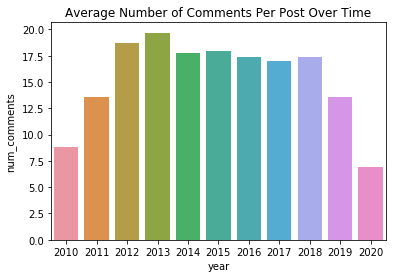

In [40]:
comm_df = sub_df.loc[:,["year", "num_comments"]].dropna().groupby("year")\
                                                .mean().reset_index()
ax = sns.barplot(x=comm_df.year, y=comm_df.num_comments)
ax.set_title("Average Number of Comments Per Post Over Time")

## Active Number of Users on R/Opiates Over Time

In [18]:
def users_per_year(df: pd.DataFrame) -> Tuple[List[str], List[int]]:
    """
    Find the number of unique users per year in the given df.
    
    Note: assumes columns names "username" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    user_counts: List[int] = [df.loc[df.year == year, "username"].unique().shape[0] for year in years]
    return years, user_counts

Text(0.5, 1.0, 'Number of r/opiates Active Users Over Time')

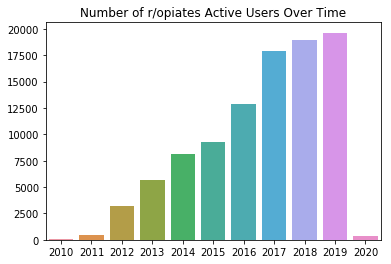

In [19]:
years, user_counts = users_per_year(full_df)
ax = sns.barplot(x=years, y=user_counts)
ax.set_title("Number of r/opiates Active Users Over Time")

## Number of Posts Over Time

### 1. Count of Submissions Over Time

Text(0.5, 1.0, 'Number of r/opiates Submissions Over Time')

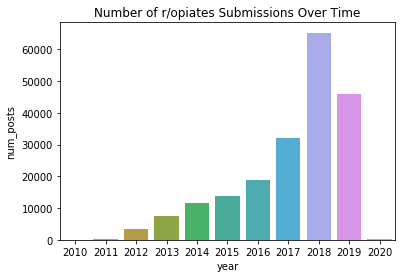

In [39]:
count_df = sub_df.groupby("year").count().reset_index().loc[:, ["year", "_id"]]
count_df.columns = ["year", "num_posts"]
norm_posts: List[float] = [p / u for p, u in zip(count_df["num_posts"], user_counts)]
ax = sns.barplot(x=count_df.year, y=count_df["num_posts"])
ax.set_title("Number of r/opiates Submissions Over Time")

### 2. Count of Submissions + Comments Over Time

In [44]:
real_comm_query = [
    {
        "$match": {
            "is_sub": True
        }
    },
    {
        "$group": {
            "_id": {
                "year": {"$year": "$time"}
            },
            "count": {
                "$sum": "$num_comments"
            }
        }
    }
]
real_res = COLL.aggregate(real_comm_query)
real_df = pd.DataFrame(list(real_res))
real_df["year"] = real_df["_id"].apply(lambda x: x["year"])

In [45]:
# group by year
raw_query = [
    {
        "$match": {
            "is_sub": False
        }
    },
    { 
        "$group": { 
            "_id": { 
                "year": {"$year": "$time"}
            }, 
            "count": {
                "$sum": 1
            }
        }
    }
]
raw_res = COLL.aggregate(raw_query)
raw_df = pd.DataFrame(list(raw_res))
raw_df["year"] = raw_df["_id"].apply(lambda x: x["year"])

In [46]:
real_df.head()

,_id,count,year
0,{'year': 2020},108924,2020
1,{'year': 2013},150417,2013
2,{'year': 2019},505189,2019
3,{'year': 2014},203636,2014
4,{'year': 2017},488484,2017


In [47]:
raw_df.head()

,_id,count,year
0,{'year': 2020},115028,2020
1,{'year': 2015},249263,2015
2,{'year': 2017},471278,2017
3,{'year': 2016},331118,2016
4,{'year': 2018},368247,2018


In [48]:
# combine dataframes
comm_df = real_df.merge(raw_df, on="year", how="inner")

In [49]:
comm_df

,_id_x,count_x,year,_id_y,count_y
0,{'year': 2020},108924,2020,{'year': 2020},115028
1,{'year': 2013},150417,2013,{'year': 2013},150380
2,{'year': 2019},505189,2019,{'year': 2019},310023
3,{'year': 2014},203636,2014,{'year': 2014},207919
4,{'year': 2017},488484,2017,{'year': 2017},471278
5,{'year': 2015},245379,2015,{'year': 2015},249263
6,{'year': 2016},327616,2016,{'year': 2016},331118
7,{'year': 2018},592090,2018,{'year': 2018},368247
8,{'year': 2012},63615,2012,{'year': 2012},63393
9,{'year': 2011},3643,2011,{'year': 2011},3675


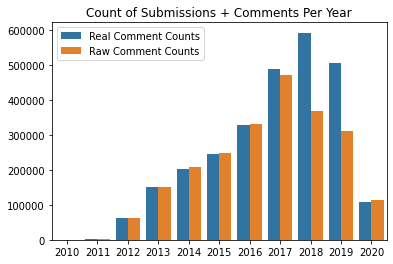

In [50]:
# plot
years = comm_df["year"].tolist() * 2
label = ["Real Comment Counts"] * comm_df.shape[0] + \
        ["Raw Comment Counts"] * comm_df.shape[0]
counts = comm_df["count_x"].tolist() + comm_df["count_y"].tolist()
ax = sns.barplot(x=years, y=counts, hue=label)
ax.set_title("Count of Submissions + Comments Per Year")
plt.show()

## 3. Count of Submissions + Real Comments

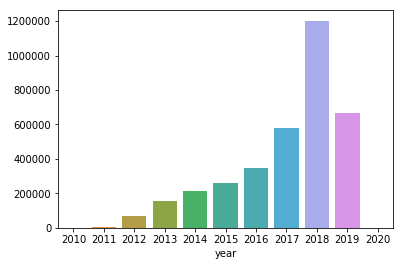

In [55]:
sub_df.query("year == '2017'").shape[0]
comms = sub_df.groupby("year")["num_comments"].sum().tolist()
subs = sub_df.groupby("year").count()
combined = [a + b for a, b in zip(comms, subs["hash"].tolist())]
sns.barplot(x=subs.index, y=combined)

In [57]:
comm_counts = full_df.groupby("parent_id").count().reset_index()
comm_counts["new_par_id"] = comm_counts["parent_id"].apply(lambda x: x.replace("t1_", ""))

In [66]:
sub_df.merge(comm_counts, how="inner", left_on="pid", right_on="new_par_id")

,_id_x,hash_x,is_sub_x,num_comments_x,parent_id_x,pid_x,subr_x,text_x,time_x,title_x,...,num_comments_y,pid_y,subr_y,text_y,time_y,title_y,username_y,year_y,date,new_par_id


In [69]:
sub_df.query("pid == '1a0j42'")

,_id,hash,is_sub,num_comments,parent_id,pid,subr,text,time,title,username,year
120603,5e45fa48d9fddf046af68b7c,8711508881785506729,True,4.0,NaN,1a0j42,opiates,I did ~.5 mg about 30 mins ago. I feel alright...,2013-03-10 11:04:42,Suboxone,istealbarbeques,2013


In [70]:
comm_counts.head()

,parent_id,_id,hash,is_sub,num_comments,pid,subr,text,time,title,username,year,date,new_par_id
0,t1_c0pfopy,1,1,1,0,1,1,1,1,0,1,1,1,c0pfopy
1,t1_c0pjl4r,2,2,2,0,2,2,2,2,0,2,2,2,c0pjl4r
2,t1_c0pk1zn,2,2,2,0,2,2,2,2,0,2,2,2,c0pk1zn
3,t1_c0puy8n,1,1,1,0,1,1,1,1,0,1,1,1,c0puy8n
4,t1_c0pwvyk,1,1,1,0,1,1,1,1,0,1,1,1,c0pwvyk


## Word Usage Over Time

In [78]:
def word_per_year(df: pd.DataFrame, words: List[str], user_counts: List[int]) -> pd.DataFrame:
    """
    Find the number of occurrences of the word per year in the df.
    Also returns a column with word counts normalized by active user counts.
    
    Note: assumes columns names "text" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    check_in = lambda text: 1 if len(set(words) & set(str(text).split())) > 0 else 0
    countw = lambda year: df.loc[df.year == year, "lower_text"].apply(check_in).sum()
    word_counts: List[int] = [countw(year) for year in years]
    wc_norm: List[float] = [w / u for w, u in zip(word_counts, user_counts)]
    return pd.DataFrame({"years": years, "word_counts": word_counts, "wc_norm": wc_norm})

def append_wc(df: pd.DataFrame, words: List[List[str]], user_counts: List[int]) -> pd.DataFrame:
    """Generates a dataframe with multiple word counts for visualization."""
    wc_df = ft.reduce(lambda acc, w: acc.append(word_per_year(df, w, user_counts)), words, pd.DataFrame())
    nyear = df.year.unique().shape[0]
    word_arr = ft.reduce(lambda acc, w: acc + [w[0]] * nyear, words, [])
    wc_df["words"] = word_arr
    return wc_df

### 1. Word Count by Location

In [83]:
# get raw and normalized word counts in df
# NOTE: words is a 2d list with:
# dim 1: a category to count and plot
# dim 2: aliases to include in that category.  can only be a single word for now
loc_words = [["boston", "beantown", "bos"], ["lawrence"], ["lowell"], ["manchester"], ["worcester"]]
loc_df = append_wc(full_df, loc_words, user_counts)

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

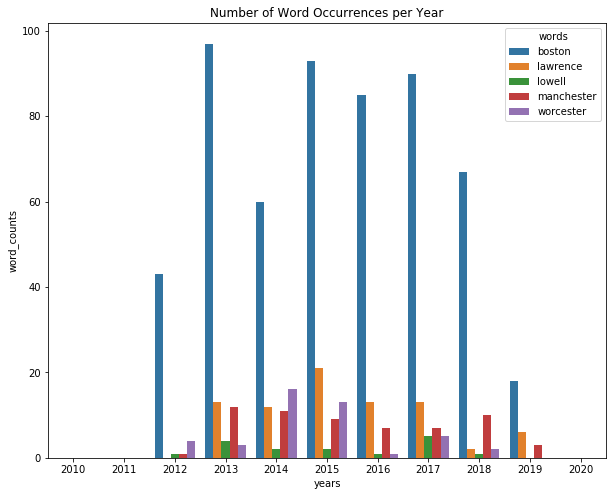

In [84]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="years", y="word_counts", hue="words", data=wc_df)
ax.set_title(f"Number of Word Occurrences per Year")

### 2. Drug Count by Location

In [85]:
drug_words = [["fentanyl", "fent", "fenty"], ["heroin"]]
drug_df = append_wc(full_df, drug_words, user_counts)

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

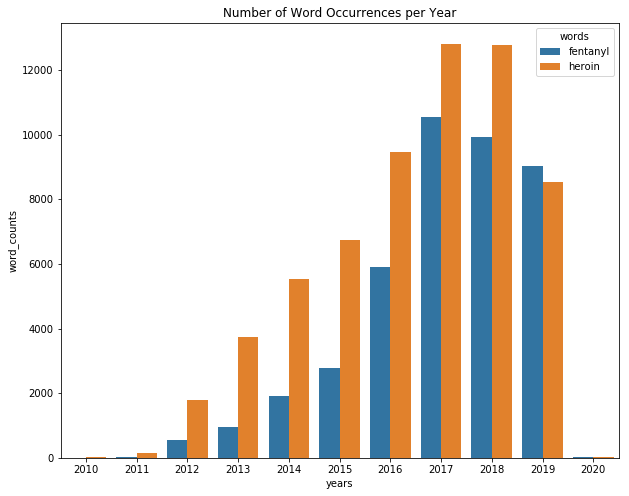

In [86]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="years", y="word_counts", hue="words", data=drug_df)
ax.set_title(f"Number of Word Occurrences per Year")

## Frequency Table

In [2]:
freq_df = pd.DataFrame(list(COLL.find({})))
freq_df["year"] = freq_df.time.apply(lambda x: str(x.year))

In [3]:
freq_df["Threads"] = freq_df["is_sub"].apply(lambda x: 1 if x else 0)
freq_df["Comments"] = freq_df["is_sub"].apply(lambda x: 1 if (not x) else 0)
freq_df["Totals"] = [1] * freq_df.shape[0]
count_df = freq_df.groupby("year").sum().loc[:,["Threads", "Comments", "Totals"]]

In [11]:
count_df

,Threads,Comments,Totals
year,,,
2010,42.0,359.0,401.0
2011,268.0,3675.0,3943.0
2012,3397.0,63393.0,66790.0
2013,7642.0,150380.0,158022.0
2014,11462.0,207919.0,219381.0
2015,13701.0,249263.0,262964.0
2016,18822.0,331118.0,349940.0
2017,29585.0,471278.0,500863.0
2018,40773.0,368247.0,409020.0
